# 1. Load the Tokenizer, Label Encoder, and Preprocessed Data

In [1]:
import numpy as np
import pickle
from tensorflow.keras.utils import to_categorical

# Load preprocessed data
X_train_padded = np.load('preprocessed_data/X_train_padded.npy')
X_test_padded = np.load('preprocessed_data/X_test_padded.npy')
y_train = np.load('preprocessed_data/y_train.npy')
y_test = np.load('preprocessed_data/y_test.npy')

# Load tokenizer
with open('preprocessed_data/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Load label encoder
with open('preprocessed_data/label_encoder.pickle', 'rb') as handle:
    label_encoder = pickle.load(handle)

# Load parameters
with open('preprocessed_data/parameters.pickle', 'rb') as handle:
    parameters = pickle.load(handle)

# Extract necessary parameters
max_sequence_length = parameters['max_sequence_length']
vocab_size = parameters['vocab_size']
num_classes = parameters['num_classes']

# Convert labels to categorical if not already done
y_train_categorical = to_categorical(y_train, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

# Print some information to verify the data
print(f"X_train shape: {X_train_padded.shape}")
print(f"X_test shape: {X_test_padded.shape}")
print(f"y_train shape: {y_train_categorical.shape}")
print(f"y_test shape: {y_test_categorical.shape}")
print(f"Vocabulary size: {vocab_size}")
print(f"Number of classes: {num_classes}")
print(f"Max sequence length: {max_sequence_length}")

2024-10-07 01:52:19.674029: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 01:52:19.746134: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 01:52:19.775305: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-07 01:52:19.888983: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-07 01:52:21.249645: W tensorflow/compiler/tf2

X_train shape: (30352, 10225)
X_test shape: (7588, 10225)
y_train shape: (30352, 6)
y_test shape: (7588, 6)
Vocabulary size: 554936
Number of classes: 6
Max sequence length: 10225


# 2. Reduce the Sequence Length to 500

In [2]:
max_sequence_length = min(500, X_train_padded.shape[1])
X_train_padded = X_train_padded[:, :max_sequence_length]
X_test_padded = X_test_padded[:, :max_sequence_length]

# 3. Update the Vocabulary Size

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer

max_words = 50000
new_tokenizer = Tokenizer(num_words=max_words)
new_tokenizer.fit_on_texts(tokenizer.sequences_to_texts(X_train_padded))

X_train_padded = new_tokenizer.texts_to_sequences(tokenizer.sequences_to_texts(X_train_padded))
X_test_padded = new_tokenizer.texts_to_sequences(tokenizer.sequences_to_texts(X_test_padded))

vocab_size = min(max_words, len(new_tokenizer.word_index) + 1)

# 4. Pad the Sequences to the New Max Sequence Length

In [4]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_padded = pad_sequences(X_train_padded, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_padded, maxlen=max_sequence_length)

# 5. Verify the Updated Data

In [5]:
print(f"Updated X_train shape: {X_train_padded.shape}")
print(f"Updated X_test shape: {X_test_padded.shape}")
print(f"Updated vocabulary size: {vocab_size}")
print(f"Updated max sequence length: {max_sequence_length}")

Updated X_train shape: (30352, 500)
Updated X_test shape: (7588, 500)
Updated vocabulary size: 50000
Updated max sequence length: 500


# 6. Create a Simple RNN Model

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Common parameters
embedding_dim = 100
num_classes = 6
max_sequence_length = 500
vocab_size = 50000

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Function to create a simple RNN model
def create_simple_rnn():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_sequence_length),
        SimpleRNN(128),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Function to compile and fit the model
def compile_and_fit(model, name):
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(
        X_train_padded, y_train_categorical,
        epochs=40,
        batch_size=64,
        validation_split=0.1,
        callbacks=[early_stopping],
        verbose=1 
    )
    return history

# Function to evaluate the model
def evaluate_model(model, name):
    loss, accuracy = model.evaluate(X_test_padded, y_test_categorical, verbose=0)
    print(f"{name} - Test accuracy: {accuracy:.4f}")

# 7. Compile, Fit, and Evaluate the Simple RNN Model

In [7]:
simple_rnn_model = create_simple_rnn()
simple_rnn_model.summary()

/home/shavinda/workspace/conda_envs/deep_learning/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1728246206.824360    3849 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728246206.959683    3849 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728246206.959730    3849 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728246206.962292    3849 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
simple_rnn_history = compile_and_fit(simple_rnn_model, "Simple RNN")
evaluate_model(simple_rnn_model, "Simple RNN")

Epoch 1/40


I0000 00:00:1728246208.920333    4327 service.cc:146] XLA service 0x7fac600036d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728246208.920392    4327 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-10-07 01:53:28.968798: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-07 01:53:29.176057: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  1/427 ━━━━━━━━━━━━━━━━━━━━ 21:54 3s/step - accuracy: 0.2969 - loss: 1.7351

I0000 00:00:1728246210.452889    4327 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


427/427 ━━━━━━━━━━━━━━━━━━━━ 72s 161ms/step - accuracy: 0.5152 - loss: 1.1482 - val_accuracy: 0.6439 - val_loss: 1.2743
Epoch 2/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 68s 158ms/step - accuracy: 0.7338 - loss: 0.9304 - val_accuracy: 0.8551 - val_loss: 0.5948
Epoch 3/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 67s 158ms/step - accuracy: 0.8488 - loss: 0.5963 - val_accuracy: 0.8554 - val_loss: 0.5839
Epoch 4/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 67s 157ms/step - accuracy: 0.8314 - loss: 0.6013 - val_accuracy: 0.6143 - val_loss: 0.9795
Epoch 5/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 68s 159ms/step - accuracy: 0.7343 - loss: 0.8132 - val_accuracy: 0.7981 - val_loss: 0.7025
Epoch 6/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 68s 160ms/step - accuracy: 0.8617 - loss: 0.5160 - val_accuracy: 0.8198 - val_loss: 0.6955
Simple RNN - Test accuracy: 0.8536


In [25]:
# Print Accuracy and Loss as  percentages
print(f"Accuracy: {simple_rnn_history.history['accuracy'][-1] * 100:.2f}%")
print(f"Validation Accuracy: {simple_rnn_history.history['val_accuracy'][-1] * 100:.2f}%")

print(f"Loss: {simple_rnn_history.history['loss'][-1]:.4f}")
print(f"Validation Loss: {simple_rnn_history.history['val_loss'][-1]:.4f}")

Accuracy: 85.78%
Validation Accuracy: 81.98%
Loss: 0.5178
Validation Loss: 0.6955


# 8. Plot the Training History

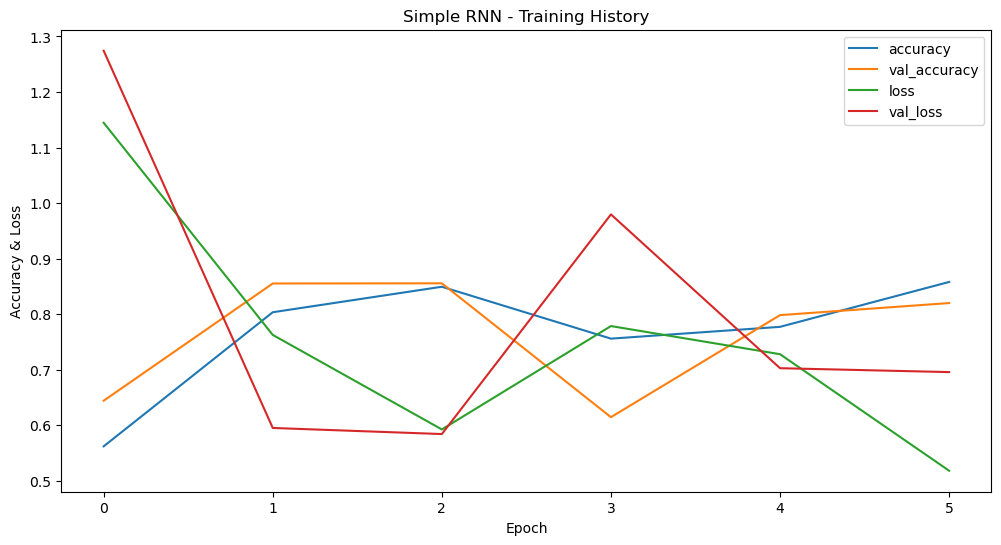

In [9]:
# Plot the training history
import matplotlib.pyplot as plt

def plot_history(history, name):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'{name} - Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy & Loss')
    plt.legend()
    plt.show()
    
plot_history(simple_rnn_history, "Simple RNN")

In [14]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

y_pred = simple_rnn_model.predict(X_test_padded)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

cm = confusion_matrix(y_true, y_pred)
print(cm)


238/238 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step
[[   0    0    0  160    0   11]
 [   0    0    0   69    0   14]
 [   0    0    0  105    0    6]
 [   0    0    0 3526    0   97]
 [   0    0    0  488    1    3]
 [   0    0    0  158    0 2950]]


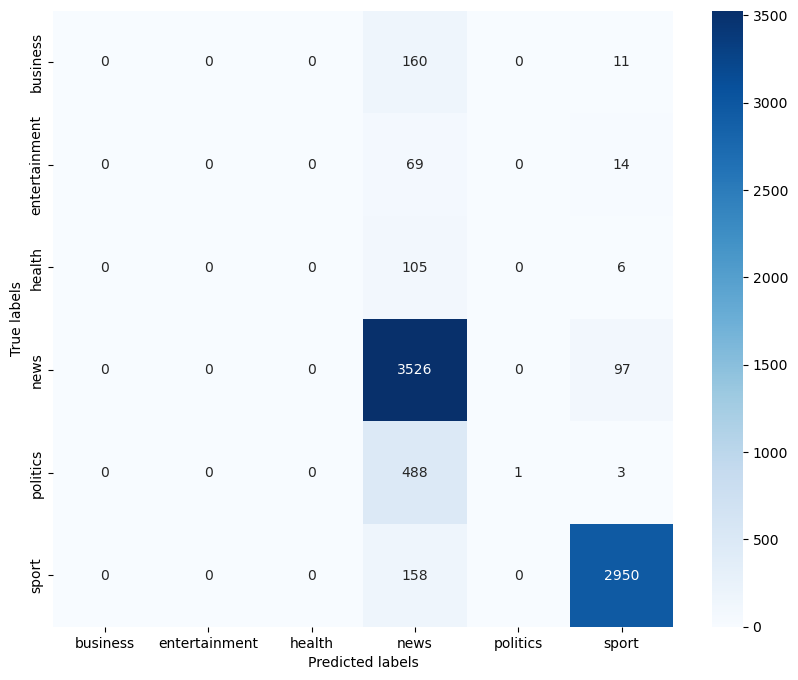

In [15]:
# Visualize the confusion matrix
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


In [16]:
# Classification report and accuracy
from sklearn.metrics import classification_report, accuracy_score

print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")

               precision    recall  f1-score   support

     business       0.00      0.00      0.00       171
entertainment       0.00      0.00      0.00        83
       health       0.00      0.00      0.00       111
         news       0.78      0.97      0.87      3623
     politics       1.00      0.00      0.00       492
        sport       0.96      0.95      0.95      3108

     accuracy                           0.85      7588
    macro avg       0.46      0.32      0.30      7588
 weighted avg       0.83      0.85      0.80      7588

Accuracy: 0.8536


/home/shavinda/workspace/conda_envs/deep_learning/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shavinda/workspace/conda_envs/deep_learning/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shavinda/workspace/conda_envs/deep_learning/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [20]:
# Save the model
simple_rnn_model.save('models/simple_rnn_model.h5')

# Save the history
with open('models/simple_rnn_history.pickle', 'wb') as handle:
    pickle.dump(simple_rnn_history.history, handle)

# 9. Create an Improved Simple RNN Model

In [10]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import SimpleRNN,BatchNormalization, Dropout
from tensorflow.keras.models import Sequential

def create_improved_simple_rnn():
    model = Sequential([
        Embedding(vocab_size, embedding_dim),
        SimpleRNN(128, return_sequences=True),
        SimpleRNN(128, return_sequences=True),
        SimpleRNN(64),
        Dropout(0.3),
        Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))
    ])
    return model

# Updated compile_and_fit function
def compile_and_fit(model, name):
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train_padded, y_train_categorical,
        epochs=40,
        batch_size=64,
        validation_split=0.1,
        callbacks=[early_stopping],
        verbose=1
    )
    return history

# 10. Compile, Fit, and Evaluate the Improved Simple RNN Model

In [11]:
improved_simple_rnn_model = create_improved_simple_rnn()
improved_simple_rnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [12]:
improved_simple_rnn_history = compile_and_fit(improved_simple_rnn_model, "Improved Simple RNN")
evaluate_model(improved_simple_rnn_model, "Improved Simple RNN")

Epoch 1/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 245s 563ms/step - accuracy: 0.4544 - loss: 1.2820 - val_accuracy: 0.0629 - val_loss: 2.3438
Epoch 2/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 199s 467ms/step - accuracy: 0.4140 - loss: 1.4944 - val_accuracy: 0.8498 - val_loss: 0.6329
Epoch 3/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 214s 500ms/step - accuracy: 0.8271 - loss: 0.7083 - val_accuracy: 0.8594 - val_loss: 0.5801
Epoch 4/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 205s 480ms/step - accuracy: 0.6908 - loss: 0.9101 - val_accuracy: 0.4097 - val_loss: 1.8072
Epoch 5/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 199s 467ms/step - accuracy: 0.7606 - loss: 0.8513 - val_accuracy: 0.8547 - val_loss: 0.5858
Epoch 6/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 204s 477ms/step - accuracy: 0.8502 - loss: 0.5909 - val_accuracy: 0.8080 - val_loss: 0.7059
Epoch 7/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 202s 471ms/step - accuracy: 0.8465 - loss: 0.5936 - val_accuracy: 0.8254 - val_loss: 0.6597
Epoch 8/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 218s 512ms/step - accuracy: 0.8651 -

In [24]:
# Print Accuracy and Loss as  percentages
print(f"Accuracy: {improved_simple_rnn_history.history['accuracy'][-1] * 100:.2f}%")
print(f"Validation Accuracy: {improved_simple_rnn_history.history['val_accuracy'][-1] * 100:.2f}%")

print(f"Loss: {improved_simple_rnn_history.history['loss'][-1]:.4f}")
print(f"Validation Loss: {improved_simple_rnn_history.history['val_loss'][-1]:.4f}")


Accuracy: 86.36%
Validation Accuracy: 85.21%
Loss: 0.5289
Validation Loss: 0.5862


# 11. Plot the Training History of the Improved Simple RNN Model

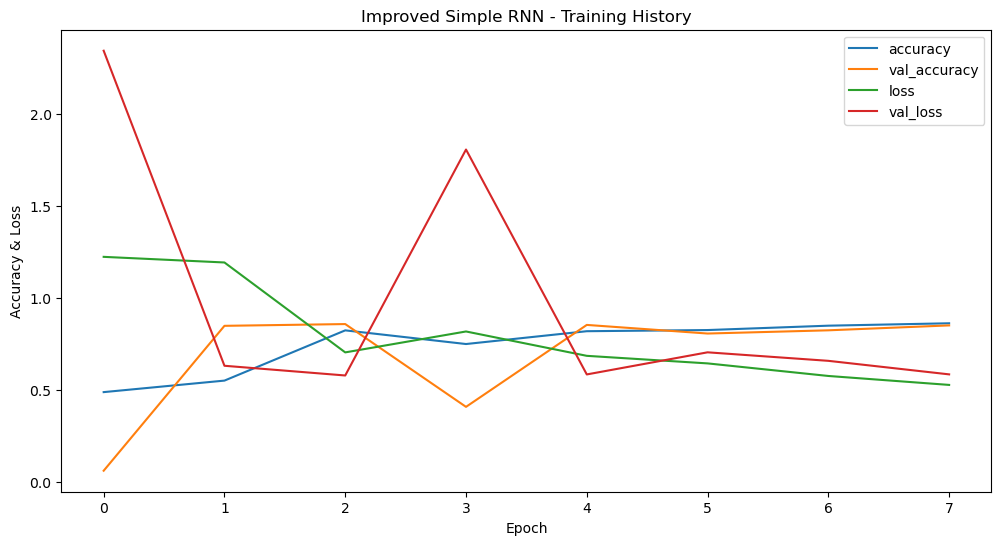

In [13]:
# Plot the training history
plot_history(improved_simple_rnn_history, "Improved Simple RNN")

In [17]:
# Confusion matrix
y_pred = improved_simple_rnn_model.predict(X_test_padded)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred)
print(cm)

238/238 ━━━━━━━━━━━━━━━━━━━━ 72s 302ms/step
[[   0    0    0  167    0    4]
 [   0    0    0   71    0   12]
 [   0    0    0  110    0    1]
 [   0    0    0 3519    0  104]
 [   0    0    0  490    0    2]
 [   0    0    0   97    0 3011]]


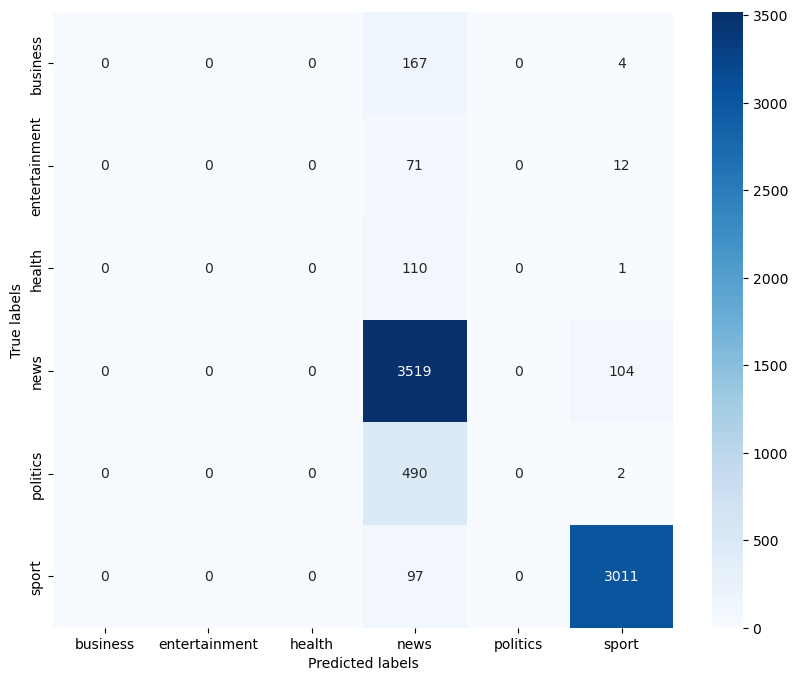

In [18]:
# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
# Classification report and accuracy
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")

In [21]:
# Save the model
improved_simple_rnn_model.save('models/improved_simple_rnn_model.h5')

# Save the history
with open('models/improved_simple_rnn_history.pickle', 'wb') as handle:
    pickle.dump(improved_simple_rnn_history.history, handle)   